<a href="https://colab.research.google.com/github/SeongBeomLEE/RecsysTutorial/blob/main/NCF/Neural_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 구현 내용

- 데이터셋 분리
- 우선 전체 데이터셋으로 positive 셋과 negative 셋을 구하자
- 학습용 데이터 셋 <- 모든 데어터가 다 1, 이후에 네거티브 샘플링이 추가됨
- 테스트용 데이터 셋 <- 제일 첫번째만 1(제일 마지막 시청 기록으로 사용) 나머지는 다 0(네가티브 셋에서 99개 샘플링)


- 모델 설정
- GMF - adam / embedding은 정규 분포에서 초기화, 표준편차 0.01 / Layer=64,1 / bias - False,
- MLP - adam / embedding은 정규 분포에서 초기화, 표준편차 0.01 / Layer=128,64,32,1 / bias = True,
- NeuMF - SGD / GMF와 MLP의 pretrain된 파라미터로 구성된 모델 / GMF + MLP(64), 1 / bias - False,


- 메트릭 설정
- NDCG@K, HR@K
- NDCG@K의 경우 top_k에 안에 정답 셋이 몇번째 idx에 존재하는 지 판단하여 그 값으로 계산 (추후에 평균을 냄)
- HR@K의 경우 top_k에 안에 정답 셋이 존재하면 1을 반환 (추후에 평균을 냄)

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import warnings
from tqdm import tqdm

warnings.filterwarnings(action='ignore')

data_dir = '/content/drive/MyDrive/RecsysTutorial/Data/MovieLens/'
model_dir = '/content/drive/MyDrive/RecsysTutorial/Model/'

# 데이터 확인

In [2]:
ratings_df = pd.read_csv(data_dir + 'ratings.csv')
ratings_df.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [3]:
num_user = ratings_df['userId'].nunique()
num_item = ratings_df['movieId'].nunique()

sparsity = 1 - len(ratings_df) / (num_user * num_item)

print(f'전체 User 수: {num_user}')
print(f'전체 Item 수: {num_item}')
print(f'행렬의 희소성: {sparsity:.4f}')

전체 User 수: 671
전체 Item 수: 9066
행렬의 희소성: 0.9836


Text(0.5, 1.0, 'Rating distribution')

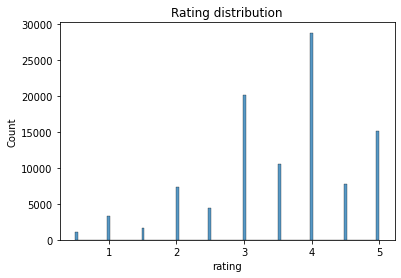

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(ratings_df['rating'])
plt.title('Rating distribution')

# 데이터셋 제작

In [5]:
user_encoder, user_decoder = {}, {}
for idx, user_id in enumerate(ratings_df['userId'].unique()):
    user_encoder[user_id] = idx
    user_decoder[idx] = user_id

item_encoder, item_decoder = {}, {}
for idx, item_id in enumerate(ratings_df['movieId'].unique()):
    item_encoder[item_id] = idx
    item_decoder[idx] = item_id

In [6]:
ratings_df['en_userId'] = ratings_df['userId'].apply(lambda x : user_encoder[x])
ratings_df['en_movieId'] = ratings_df['movieId'].apply(lambda x : item_encoder[x])

In [21]:
# 논문에서 제공된 깃허브의 데이터를 보면
# test 데이터셋이 100개의 데이터 중 첫번째 데이터를 제외한 나머지 99개 데이터는 모두 neg 데이터라고 함
# 따라서 이에 맞춰서 데이터를 나눔

def split_data(df, num_neg = 2):
    total_item_li = set([i for i in range(num_item)])
    train_df = []
    test_df = []
    en_user_id_li = df['en_userId'].unique()
    for en_user_id in tqdm(en_user_id_li):
        pos_recomencder_li = df[df['en_userId'] == en_user_id]['en_movieId'].tolist()
        neg_recomencder_li = np.random.choice(list(total_item_li - set(pos_recomencder_li)), num_neg * len(pos_recomencder_li), replace = False).tolist()
        train_df += [[en_user_id, en_movieId, 1] for en_movieId in pos_recomencder_li[:-1]] + [[en_user_id, en_movieId, 0] for en_movieId in neg_recomencder_li]

        neg_recomencder_li = np.random.choice(list(total_item_li - set(pos_recomencder_li)), 99, replace = False).tolist()
        test_df += [[en_user_id, pos_recomencder_li[-1], 1]] + [[en_user_id, en_movieId, 0] for en_movieId in neg_recomencder_li]
    
    return train_df, test_df

In [22]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        user = self.df[idx][0]
        item = self.df[idx][1]
        label = self.df[idx][2]

        return user, item, label

# GMF

In [23]:
class GMF(nn.Module):
    def __init__(self, num_user, num_item, num_factor):
        super(GMF, self).__init__()
        self.user_emb = nn.Embedding(num_user, num_factor)
        self.item_emb = nn.Embedding(num_item, num_factor)
        
        self.predict_layer = nn.Sequential(
            nn.Linear(num_factor, 1, bias = False),
            nn.Sigmoid()
        )

        self._init_weight_()
    
    def _init_weight_(self):
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")
    
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)

        output = self.predict_layer(user_emb * item_emb)

        return output.view(-1)

# MLP

In [24]:
class MLP(nn.Module):
    def __init__(self, num_user, num_item, num_factor, num_layers, dropout):
        super(MLP, self).__init__()
        self.dropout = dropout
        self.user_emb = nn.Embedding(num_user, num_factor)
        self.item_emb = nn.Embedding(num_item, num_factor)

        MLP_modules = []
        input_size = num_factor * 2
        for i in range(num_layers):
            MLP_modules.append(nn.Dropout(p = self.dropout))
            MLP_modules.append(nn.Linear(input_size, input_size // 2))
            MLP_modules.append(nn.ReLU())
            input_size = input_size // 2
        self.MLP_layers = nn.Sequential(*MLP_modules)

        self.predict_layer = nn.Sequential(
            nn.Linear(input_size, 1, bias = False),
            nn.Sigmoid()
        )

        self._init_weight_()
    
    def _init_weight_(self):
        nn.init.normal_(self.user_emb.weight, std=0.01)
        nn.init.normal_(self.item_emb.weight, std=0.01)
        for m in self.MLP_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
        
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")
    
    def forward(self, user, item):
        user_emb = self.user_emb(user)
        item_emb = self.item_emb(item)
        
        cat_emb = torch.cat((user_emb, item_emb), -1)

        output = self.MLP_layers(cat_emb)

        output = self.predict_layer(output)

        return output.view(-1)

# NeuMF

In [25]:
class NeuMF(nn.Module):
    def __init__(self, GMF, MLP, num_factor):
        super(NeuMF, self).__init__()
        self.gmf_user_emb = GMF.user_emb
        self.gmf_item_emb = GMF.item_emb

        self.mlp_user_emb = MLP.user_emb
        self.mlp_item_emb = MLP.item_emb

        self.mlp_layer = MLP.MLP_layers

        self.predict_layer = nn.Sequential(
            nn.Linear(num_factor + (num_factor // 2), 1, bias = False),
            nn.Sigmoid(),
        )
        self._init_weight_()
    
    def _init_weight_(self):
        for m in self.predict_layer:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=1, nonlinearity="sigmoid")

    def forward(self, user, item):
        gmf_user_emb = self.gmf_user_emb(user)
        gmf_item_emb = self.gmf_item_emb(item)
        gmf_output = gmf_user_emb * gmf_item_emb

        mlp_user_emb = self.mlp_user_emb(user)
        mlp_item_emb = self.mlp_item_emb(item)
        mlp_cat_emb = torch.cat((mlp_user_emb, mlp_item_emb), -1)
        mlp_output = self.mlp_layer(mlp_cat_emb)
        
        cat_output = torch.cat((gmf_output, mlp_output), -1)

        output = self.predict_layer(cat_output)

        return output.view(-1)

# 학습 설정

In [36]:
def hit(target_item, pred_items):
    if target_item in pred_items:
        return 1
    return 0

def ndcg(target_item, pred_items):
    if target_item in pred_items:
        idx = pred_items.index(target_item)
        # 초기 인덱스가 0이기 때문에 +2 함
        return np.reciprocal(np.log2(idx + 2))
    return 0

def metrics(model, test_loader, top_k):
    model.eval()
    HR, NDCG = [], []
    with torch.no_grad():
        for user, item, _ in test_loader:
            user = user.to(device)
            item = item.to(device)

            predictions = model(user, item)
            # 가장 높은 top_k개 선택
            _, indices = torch.topk(predictions, top_k)
            # 해당 상품 index 선택
            recommends = torch.take(item, indices).cpu().numpy().tolist()
            # 정답값 선택
            target_item = item[0].item()
            HR.append(hit(target_item, recommends))
            NDCG.append(ndcg(target_item, recommends))

    return np.mean(HR), np.mean(NDCG)
    
def train(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.to(device)
        label = label.float()

        optimizer.zero_grad()
        output = model(user, item)
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)

    return train_loss

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size = 256
epochs = 30
lr = 0.005
num_factor = 64
num_layers = 2
dropout = 0.2
top_k = 30
num_neg = 2

In [38]:
train_df, test_df = split_data(df = ratings_df, num_neg = num_neg)

100%|██████████| 671/671 [00:02<00:00, 265.04it/s]


In [39]:
train_dataset = CustomDataset(df = train_df)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = False)

test_dataset = CustomDataset(df = test_df)
test_loader = DataLoader(test_dataset, batch_size = 100, shuffle = False, drop_last = False)

# GMF + MLP 학습

In [40]:
gmf = GMF(num_user = num_user, num_item = num_item, num_factor = num_factor).to(device)
gmf_optimizer = torch.optim.Adam(gmf.parameters(), lr = lr)

mlp = MLP(num_user = num_user, num_item = num_item, num_factor = num_factor, num_layers = num_layers, dropout = dropout).to(device)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr = lr)

loss_fc = nn.BCELoss()

In [41]:
gmf_best_metric = 0
mlp_best_metric = 0

for epoch in range(1, epochs + 1):
    gmf_train_loss = train(model = gmf, train_loader = train_loader, criterion = loss_fc, optimizer = gmf_optimizer)
    gmf_hr, gmf_ndcg = metrics(model = gmf, test_loader = test_loader, top_k = top_k)

    mlp_train_loss = train(model = mlp, train_loader = train_loader, criterion = loss_fc, optimizer = mlp_optimizer)
    mlp_hr, mlp_ndcg  = metrics(model = mlp, test_loader = test_loader, top_k = top_k)

    print(f"[EPOCH: {epoch}], GMF Train Loss: {gmf_train_loss:.4f}, MLP Train Loss: {mlp_train_loss:.4f}, GMF HR: {gmf_hr:.4f}, MLP HR: {mlp_hr:.4f}, GMF NDCG: {gmf_ndcg:.4f}, MLP NDCG: {mlp_ndcg:.4f}")

    if gmf_best_metric < gmf_ndcg:
        gmf_best_metric = gmf_ndcg
        torch.save(gmf.state_dict(), model_dir + f'GMF.pt')

    if mlp_best_metric < mlp_ndcg:
        mlp_best_metric = mlp_ndcg
        torch.save(mlp.state_dict(), model_dir + f'MLP.pt')

[EPOCH: 1], GMF Train Loss: 0.4643, MLP Train Loss: 0.4429, GMF HR: 0.7839, MLP HR: 0.7168, GMF NDCG: 0.3553, MLP NDCG: 0.3121
[EPOCH: 2], GMF Train Loss: 0.2635, MLP Train Loss: 0.4029, GMF HR: 0.7750, MLP HR: 0.7243, GMF NDCG: 0.3673, MLP NDCG: 0.3204
[EPOCH: 3], GMF Train Loss: 0.0832, MLP Train Loss: 0.3828, GMF HR: 0.7779, MLP HR: 0.7392, GMF NDCG: 0.3557, MLP NDCG: 0.3304
[EPOCH: 4], GMF Train Loss: 0.0220, MLP Train Loss: 0.3540, GMF HR: 0.7705, MLP HR: 0.7437, GMF NDCG: 0.3621, MLP NDCG: 0.3465
[EPOCH: 5], GMF Train Loss: 0.0055, MLP Train Loss: 0.3297, GMF HR: 0.7675, MLP HR: 0.7750, GMF NDCG: 0.3582, MLP NDCG: 0.3678
[EPOCH: 6], GMF Train Loss: 0.0014, MLP Train Loss: 0.3127, GMF HR: 0.7675, MLP HR: 0.7779, GMF NDCG: 0.3560, MLP NDCG: 0.3776
[EPOCH: 7], GMF Train Loss: 0.0004, MLP Train Loss: 0.2995, GMF HR: 0.7705, MLP HR: 0.7675, GMF NDCG: 0.3576, MLP NDCG: 0.3724
[EPOCH: 8], GMF Train Loss: 0.0002, MLP Train Loss: 0.2879, GMF HR: 0.7705, MLP HR: 0.7735, GMF NDCG: 0.3582, M

# NeuMF 학습

In [46]:
# NeuMF 의 경우 pre-trained 모델을 사용한다고 함
# 그리고 optimizer로 SGD를 사용한다고 함
# 실제로 Adam 보다 더 좋은 성능을 보임

gmf = GMF(num_user = num_user, num_item = num_item, num_factor = num_factor).to(device)
gmf.load_state_dict(torch.load(model_dir + f'GMF.pt'))

mlp = MLP(num_user = num_user, num_item = num_item, num_factor = num_factor, num_layers = num_layers, dropout = dropout).to(device)
mlp.load_state_dict(torch.load(model_dir + f'MLP.pt'))

nmf = NeuMF(GMF = gmf, MLP = mlp, num_factor = num_factor).to(device)
nmf_optimizer = torch.optim.SGD(nmf.parameters(), lr = lr, momentum = 0.9)

In [47]:
nmf_best_metric = 0

for epoch in range(1, epochs + 1):
    nmf_train_loss = train(model = nmf, train_loader = train_loader, criterion = loss_fc, optimizer = nmf_optimizer)
    nmf_hr, nmf_ndcg = metrics(model = nmf, test_loader = test_loader, top_k = top_k)

    print(f"[EPOCH: {epoch}], NeuMF Train Loss: {nmf_train_loss:.4f}, NeuMF HR: {nmf_hr:.4f}, NeuMF NDCG: {nmf_ndcg:.4f}")

    if nmf_best_metric < nmf_ndcg:
        nmf_best_metric = nmf_ndcg
        torch.save(nmf.state_dict(), model_dir + f'NeuMF.pt')

[EPOCH: 1], NeuMF Train Loss: 0.2048, NeuMF HR: 0.7943, NeuMF NDCG: 0.3862
[EPOCH: 2], NeuMF Train Loss: 0.1696, NeuMF HR: 0.7958, NeuMF NDCG: 0.3878
[EPOCH: 3], NeuMF Train Loss: 0.1520, NeuMF HR: 0.7928, NeuMF NDCG: 0.3911
[EPOCH: 4], NeuMF Train Loss: 0.1378, NeuMF HR: 0.7988, NeuMF NDCG: 0.3913
[EPOCH: 5], NeuMF Train Loss: 0.1274, NeuMF HR: 0.7988, NeuMF NDCG: 0.3929
[EPOCH: 6], NeuMF Train Loss: 0.1185, NeuMF HR: 0.7988, NeuMF NDCG: 0.3914
[EPOCH: 7], NeuMF Train Loss: 0.1110, NeuMF HR: 0.8003, NeuMF NDCG: 0.3953
[EPOCH: 8], NeuMF Train Loss: 0.1054, NeuMF HR: 0.8018, NeuMF NDCG: 0.3929
[EPOCH: 9], NeuMF Train Loss: 0.1001, NeuMF HR: 0.8018, NeuMF NDCG: 0.3935
[EPOCH: 10], NeuMF Train Loss: 0.0962, NeuMF HR: 0.8033, NeuMF NDCG: 0.3963
[EPOCH: 11], NeuMF Train Loss: 0.0921, NeuMF HR: 0.8018, NeuMF NDCG: 0.3902
[EPOCH: 12], NeuMF Train Loss: 0.0890, NeuMF HR: 0.7973, NeuMF NDCG: 0.3902
[EPOCH: 13], NeuMF Train Loss: 0.0862, NeuMF HR: 0.7988, NeuMF NDCG: 0.3899
[EPOCH: 14], NeuMF Tr

# 평가

In [49]:
nmf = NeuMF(GMF = gmf, MLP = mlp, num_factor = num_factor).to(device)
nmf.load_state_dict(torch.load(model_dir + f'NeuMF.pt'))

gmf = GMF(num_user = num_user, num_item = num_item, num_factor = num_factor).to(device)
gmf.load_state_dict(torch.load(model_dir + f'GMF.pt'))

mlp = MLP(num_user = num_user, num_item = num_item, num_factor = num_factor, num_layers = num_layers, dropout = dropout).to(device)
mlp.load_state_dict(torch.load(model_dir + f'MLP.pt'))

gmf_hr, gmf_ndcg = metrics(model = gmf, test_loader = test_loader, top_k = top_k)
mlp_hr, mlp_ndcg  = metrics(model = mlp, test_loader = test_loader, top_k = top_k)
nmf_hr, nmf_ndcg = metrics(model = nmf, test_loader = test_loader, top_k = top_k)

print(f"NeuMF HR: {nmf_hr:.4f}, NeuMF NDCG: {nmf_ndcg:.4f}, \n MLP HR: {mlp_hr:.4f}, MLP NDCG: {mlp_ndcg:.4f} \n GMF HR: {gmf_hr:.4f}, GMF NDCG: {gmf_ndcg:.4f}")

NeuMF HR: 0.8033, NeuMF NDCG: 0.3963, 
 MLP HR: 0.7988, MLP NDCG: 0.3914 
 GMF HR: 0.7750, GMF NDCG: 0.3673


NeuMF > MLP > GMF 순으로 모델의 성능이 우수함, 논문 보다 적은 수의 데이터 셋을 사용하였지만 논문과 비슷한 수준의 성능이 재현됨